## Dropout

### 1.动机

- 我们期待“好”的预测模型能在未知的数据上有很好的表现：经典泛化理论认为，为了缩小训练和测试性能之间的差距，应该以简单的模型为目标。
- 简单的模型：
  - 较小维度：惩罚项，正则化；
  - 平滑性：对输入数据的噪声鲁棒。
    - 使用有噪音的数据，等价于Tikhonov正则（1995）；
    - 暂退法/丢弃法：在前向传播过程中，计算每一内部层的同时注入噪声（2014）
- 标准暂退法正则化：
  - 希望无偏地加入噪音；
  - 对每个元素扰动：
  $$
  x_i^{'} = \begin{cases} 0 & & with ~ probablity ~ p \\
  \frac{x_i}{1-p} & & otherwise \end{cases}
  $$


### 2.实践中的丢弃法：

- 通常将丢弃法作用在隐藏全连接层的输出上。
- 通常，我们在测试时不用暂退法。给定一个训练好的模型和一个新的样本，我们不会丢弃任何节点，因此不需要标准化。
- 然而也有一些例外：一些研究人员在测试时使用暂退法，用于估计神经网络预测的“不确定性”：如果通过许多不同的暂退法遮盖后得到的预测结果都是一致的，那么我们可以说网络发挥更稳定。

### 3.小结

- 丢弃法将一些输出项随机置0，来控制模型复杂度；
- 常作用在多层感知机的隐藏层输出上；
- 丢弃概率是空值模型复杂度的超参数。

### 4.从零开始实现

In [1]:
import torch
from torch import nn
import sys
sys.path.append('..')
import utils
import d2l

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()  # (0, 1)均匀分布
    return mask * X / (1.0 - dropout)

测试dropout

In [3]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  6.,  8.,  0., 12.,  0.],
        [ 0., 18.,  0.,  0., 24.,  0., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [4]:
# 模型参数，仍然使用fashion-MNIST
num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 10, 256, 128

# 模型
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hidden1, num_hidden2)

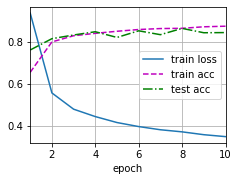

In [5]:
# 训练和测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 5.简洁实现

In [6]:
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_inputs, num_hidden1),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(num_hidden1, num_hidden2),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(num_hidden2, num_outputs))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

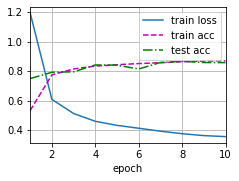

In [7]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)